# Evaluation of the final CNN model
The model was chosen in 7_CNN_model_comparison.ipynb and the hyperparameters chosen from 8_CNN_hyperparameter.ipynb.
The early stopping patience to use was decided using notebook 9.

First the model is trained on subjects A, B, D, E, F.
The model is then evaluated on the test subject C. Up until this point the model has not been exposed to this data.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_final_model_evaluation/'
HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'
MODEL_PATH = BASE_PATH + 'models/CNN_final_model_evaluation/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

Import remaining packages

In [3]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# ! pip install scikit-optimize
from skopt import load
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [5]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [ ]:
SAVE_RESULTS_TEST_C = True
SAVE_GRAPHS_TEST_C = True

SAVE_RESULTS_20 = True
SAVE_GRAPHS_20 = True

SAVE_RESULTS_6_FOLD = True
SAVE_GRAPHS_6_FOLD = True

In [6]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75

users = ["A", "B", "C", "D", "E", "F"] 

In [7]:
def load_data(user_letter):
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

        
    return data, labels

In [8]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

## Define Model

In [ ]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same', input_shape=(1, img_rows, img_cols), activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same', activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Train Model Function

In [10]:
def train_model(train_data, train_labels, test_data, test_labels, hyperparameters, epochs, patience):
    parameters = hyperparameters
    model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
               parameters[3], parameters[4], parameters[5],
               parameters[6], parameters[7])
    
    optimizer = parameters[0] 
    learning_rate = parameters[1]
    if optimizer == 'adam':
        selected_optimizer = Adam(lr=learning_rate)

    elif optimizer == 'sgd_standard':
        selected_optimizer = SGD(lr=learning_rate)

    else:
        #nestrov momentum
        selected_optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9,
                                 nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=selected_optimizer,
                  metrics=['accuracy'])
    
    callback_list = []
    if patience != -1:
        early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
        callback_list.append(early_stopping)
        
    history = model.fit(train_data, train_labels,
                        batch_size=parameters[8],
                        epochs=nb_epoch,
                        shuffle=True, 
                        validation_data=(test_data, test_labels),
                        callbacks=callbacks_list,
                        verbose=1)
    
    return history, model

## Evaluate Model function

In [11]:
def evaluate_model(model, test_data, test_labels, batch_size, target_names):
    evaluation = model.evaluate(test_data, test_labels,
                                batch_size=parameters[8], verbose=1)

    loss = evaluation[0]
    accuracy = evaluation[1]

    test_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(test_labels,axis=1),
                                   test_pred, target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), test_pred)
    return {
        "loss": loss,
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

### Load hyperparameter results

In [12]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [13]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size','batch_size']

res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")
parameters = res_gp.x

In [14]:
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


# Evaluating on subject C

In [9]:
def split_train_validation(validation_user):
    train_data = None
    train_labels = None
    first_round = True
    validation_data = []
    validation_labels = []
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        if user == validation_user:
            validation_data = data
            validation_labels = labels
            
        else:
            if first_round:
                train_data = data
                train_labels = labels
                first_round = False
            else:
                train_data = np.concatenate((train_data, data))
                train_labels = np.concatenate((train_labels, labels))
            
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    train_data = train_data.astype('float32')
    validation_data = validation_data.astype('float32')
    train_data /= 255
    validation_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels
       }

## Train Model

In [15]:
nb_epoch = 20
patience = 3

In [17]:
data_split = split_train_validation("C") # subject c is test subject
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]
test_data = data_split["validation_data"]
test_labels = data_split["validation_labels"]

In [ ]:
history, model = train_model(train_data, train_labels, test_data, test_labels, parameters, nb_epoch, patience)

## Evaluate Model

In [20]:
results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
results["history"] = history.history

7966/7966 [==============================] - 3s 360us/step


## Save Results

In [22]:
if SAVE_RESULTS_TEST_C:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [23]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

### Accuracy

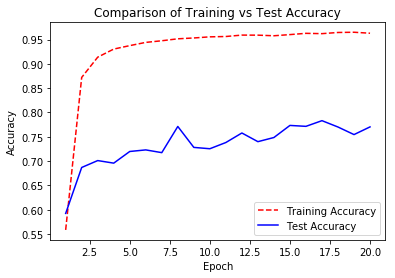

In [29]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
if True:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

### Loss

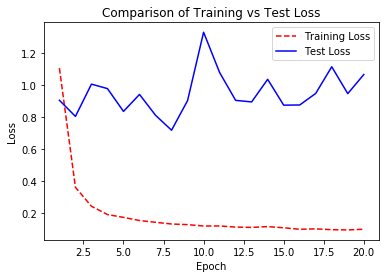

In [30]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
if True:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss.pdf", format='pdf')
plt.show()

### Confusion Matrix

In [31]:
def plot_confusion_matrix(cm, classes, save=False, path='/'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

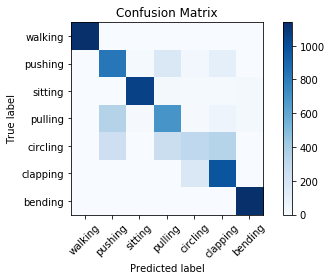

In [32]:
plot_confusion_matrix(conf_matrix, target_names,
                      save=True, path=RESULTS_PATH + "confusion_matrix.pdf")

# Evaluating on 20% of the data (all subjects)

In [81]:
# pass in percentage to make test set
def split_data(split_percentage=20.0):
    split_percentage = split_percentage/100.0
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])        
        
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    test_labels = []
    test_data = []
    for user in users:
        for label in labels:
            length = actions[user][str(label)].shape[0]
            labels_of_length = np.full(length, label)
            split_index = int(length * split_percentage)

            train_data.append(actions[user][str(label)][split_index:,:,:,:])
            train_labels.append(labels_of_length[split_index:])
            test_data.append(actions[user][str(label)][:split_index,:,:,:])
            test_labels.append(labels_of_length[:split_index])
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')
    train_data /= 255
    test_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": test_data,
        "validation_labels": test_labels
       }

In [84]:
data_split = split_data()
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]
test_data = data_split["validation_data"]
test_labels = data_split["validation_labels"]

In [82]:
nb_epoch = 20
patience = 3

In [ ]:
history, model = train_model(train_data, train_labels, test_data, test_labels, parameters, nb_epoch, patience)

## Evaluate Model

In [ ]:
results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
results["history"] = history.history

## Save Results

In [92]:
if SAVE_RESULTS_20:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [23]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

### Accuracy

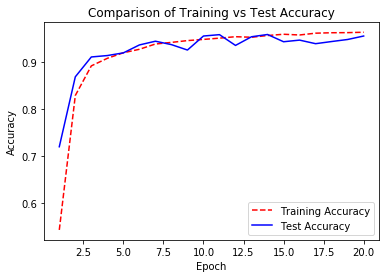

In [93]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
if True:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

### Loss

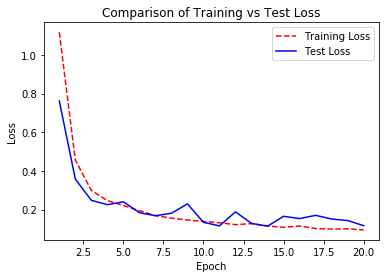

In [94]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
if True:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss.pdf", format='pdf')
plt.show()

### Confusion Matrix

In [95]:
def plot_confusion_matrix(cm, classes, save=False, path='/'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

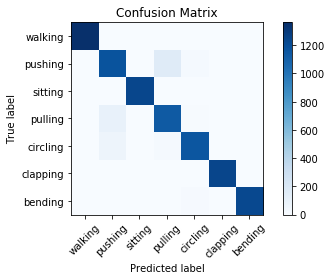

In [96]:
plot_confusion_matrix(conf_matrix, target_names,
                      save=True, path=RESULTS_PATH + "confusion_matrix.pdf")

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [ ]:
nb_epoch = 20

In [ ]:
results = {}
for user in users:
    results[user] = {}

In [ ]:
average_accuracy = 0
average_loss = 0
for user in users:
    data_split = split_train_validation(user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    
    history, model = train_model(train_data, train_labels, test_data, test_labels, parameters, nb_epoch, patience)

    
    evaluation = model.evaluate(validation_data, validation_labels,
                                batch_size=batch_size, verbose=1)

    results[user]["loss"] = evaluation["loss"]
    results[user]["accuracy"] = evaluation["accuracy"]
    average_loss += evaluation["loss"]
    average_accuracy += evaluation["accuracy"]

results["avg_loss"] = average_loss/len(users)
results["avg_acc"] = average_accuracy/len(users)
print("Average Loss:", average_loss/len(users))
print("Average Accuracy:", average_accuracy/len(users))

## Save Results

In [ ]:
if SAVE_RESULTS_6_FOLD:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [ ]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)